# Analysis of YC's top 100 Investments 

Y Combinator (YC) is one of the leading startup accelerators in the world with close to 1,000 investments over the past 15 years. Some of the world-famous investments include Dropbox, AirBnb, and Twitch. YC put together a list of it's 100 top investments in their [website](https://www.ycombinator.com/topcompanies/), which I will be analyzing today. 

There are a couple of big questions that I would like to get answers through my analysis:
* Which sectors are most represented in top 100?
* Companies in which sectors have created the most jobs?
* Which year is the most successful for YC (both in job creation and ranking)?

## The Data 

YC published the list of their top 100 investments as of October 2018. 

In order to gather the data, I scraped YC's website and inputed into a csv format. The file with the YC website scraper and the data itself are in the GitHub folder. 

The dataset consists of the following columns: 
* company - name of the company
* rank - top 100 rank 
* description - description of the business 
* founders - names of founders 
* sector - market sector
* jobs_created - number of jobs created 
* yc_batch - year and season (Winter or Summer) the company participated in Y Combinator accelerator 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

yc = pd.read_csv('yc_top100_clean.csv', delimiter=',')

yc.head()

,company,rank,description,founders,sector,jobs_created,yc_batch
0,"<b class=""h4"">Airbnb</b>","<span class=""text-center"">#01</span>",<p>Airbnb is a global travel community that of...,Brian Chesky Joe Gebbia Nathan Blecharczyk,Consumer Goods and Services,"4,000",W2009
1,"<b class=""h4"">Stripe</b>","<span class=""text-center"">#02</span>",<p>Stripe builds economic infrastructure for t...,John Collison Patrick Collison,Financial Technology and Services,"1,300",S2010
2,"<b class=""h4"">Cruise</b>","<span class=""text-center"">#03</span>",<p>Cruise is building autonomous vehicles to s...,Kyle Vogt Daniel Kan,Automotive,1000,W2014
3,"<b class=""h4"">Dropbox</b>","<span class=""text-center"">#04</span>",<p>Dropbox is a global collaboration platform ...,Arash Ferdowsi Drew Houston,B2B Software and Services,"1,858",S2007
4,"<b class=""h4"">Coinbase</b>","<span class=""text-center"">#05</span>",<p>Coinbase is a digital currency wallet and p...,Brian Armstrong Fred Ehrsam,Financial Technology and Services,500,S2012


## Data Cleaning 

We can see that the table needs a bit of cleaning before we can move forward with our analysis.
* company column only needs to have the name of the company
* rank column just needs to have the number of ranking, and converted into integer type
* description column needs to have text without p tags
* jobs_created needs to be converted into integer type
* For the yc_batch column, I would only need to extract the year 

In [2]:
# Fix the company column 
yc['company'] = yc['company'].str.replace('<b class="h4">', '').str.replace("</b>",'').str.strip()

# Fix the rank column & convert to integer
yc['rank'] = yc['rank'].str.replace('<span class="text-center">#','').str.replace('</span>','').str.strip()
yc['rank'] = yc['rank'].astype(int)

#Fix the description column 
yc['description'] = yc['description'].str.replace('<p>','').str.replace('</p>','')

# Delete the ',' and convert jobs_created to integer values 
yc['jobs_created'] = yc['jobs_created'].str.replace(',','')
yc['jobs_created'] = yc['jobs_created'].astype(int)
 
# Extract the year from yc_batch and conver to integer 
year_pattern = r'([1-2][0-9]{3})'
yc['yc_batch'] = yc['yc_batch'].str.extract(year_pattern)
yc['yc_batch'] = yc['yc_batch'].astype(int)

#Check 
yc.head()

,company,rank,description,founders,sector,jobs_created,yc_batch
0,Airbnb,1,Airbnb is a global travel community that offer...,Brian Chesky Joe Gebbia Nathan Blecharczyk,Consumer Goods and Services,4000,2009
1,Stripe,2,Stripe builds economic infrastructure for the ...,John Collison Patrick Collison,Financial Technology and Services,1300,2010
2,Cruise,3,Cruise is building autonomous vehicles to safe...,Kyle Vogt Daniel Kan,Automotive,1000,2014
3,Dropbox,4,Dropbox is a global collaboration platform whe...,Arash Ferdowsi Drew Houston,B2B Software and Services,1858,2007
4,Coinbase,5,Coinbase is a digital currency wallet and plat...,Brian Armstrong Fred Ehrsam,Financial Technology and Services,500,2012


## Most Represented Sectors 

The first questions I would like to tackle is:
* Which sectors are the most represented in the top 100? 

In [3]:
yc['sector'].value_counts()

B2B Software and Services            49
Consumer Goods and Services          16
Consumer Media                       10
Financial Technology and Services     9
Healthcare                            5
Education                             2
Automotive                            2
Industrial                            2
Consumer Goods                        1
Blockchain                            1
Agriculture                           1
Real Estate and Contruction           1
Real Estate and Construction          1
Aerospace                             1
Name: sector, dtype: int64

**Observations**

We can observe that sectors are distributed unevenly and there is a large number of sectors that only have 1 or 2 companies. In order to produce a better analysis, I will create a function to group sectors that have less than 5 companies into 'other' group. 

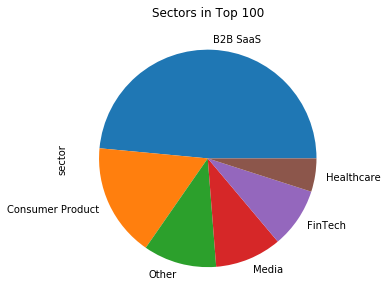

In [4]:
# create a function to group sectors 
def sector_group(name):
    if name == 'B2B Software and Services':
        return 'B2B SaaS'
    elif name == 'Consumer Goods and Services' or name == "Consumer Goods":
        return 'Consumer Product'
    elif name == 'Consumer Media':
        return 'Media'
    elif name == 'Financial Technology and Services':
        return 'FinTech'
    elif name == "Healthcare":
        return 'Healthcare'
    else: 
        return 'Other'

yc['sector'] = yc['sector'].apply(sector_group)
yc_sectors = yc['sector'].value_counts()
yc_sectors.plot(kind='pie', figsize = [10,5], title='Sectors in Top 100')
    

## Jobs Created by Sector 

Now that we know our distribution of sectors, I would like to find out companies in which sectors created more jobs in total and on average. Becuase B2B SaaS sector is the most represented sector, it's expected that it will lead in total number of jobs created. 

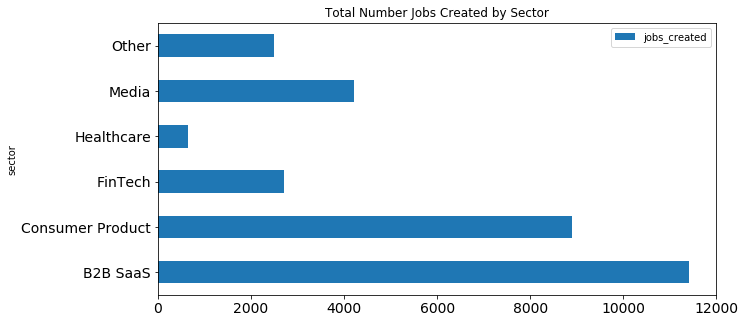

In [23]:
jobs_by_sector = yc.pivot_table(values='jobs_created', index='sector', aggfunc=np.sum)
jobs_by_sector.plot(kind='barh', figsize=(10,5), title='Total Number Jobs Created by Sector', fontsize=14)

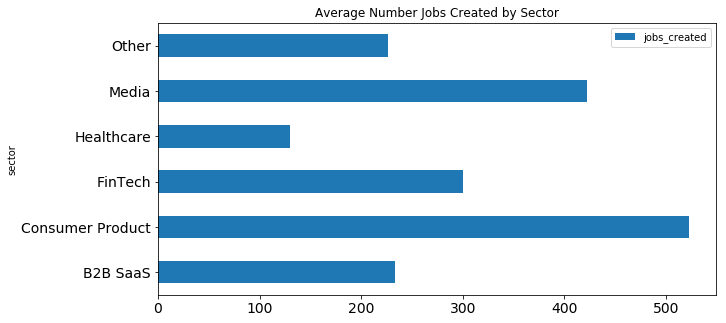

In [6]:
jobs_by_sector = yc.pivot_table(values='jobs_created', index='sector', aggfunc=np.mean)
jobs_by_sector.plot(kind='barh', figsize=(10,5), title='Average Number Jobs Created by Sector',fontsize=14)

## Ranking by Sector 

In this portion I would like to find out which sectors are better ranked within the top 100. 

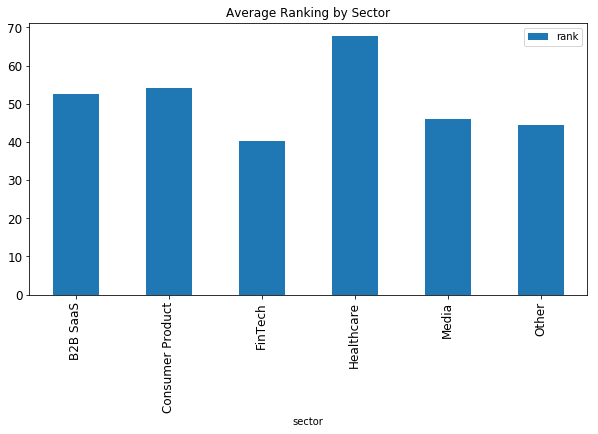

In [7]:
rank = yc.pivot_table(values='rank', index='sector')
rank.plot(kind='bar', figsize=(10,5), title='Average Ranking by Sector', fontsize=12)

## YC's best Year 

In this section I would like to find out which year was the most successful for YC when it comes to job creation and ranking of it's investments

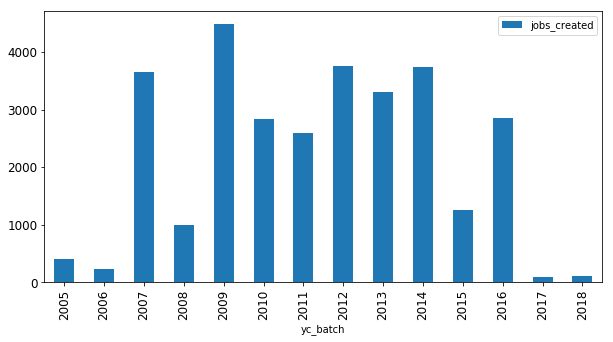

In [8]:
yc_year_jobs = yc.pivot_table(values='jobs_created', index='yc_batch', aggfunc=np.sum)
yc_year_jobs.plot(kind='bar', figsize=(10,5), fontsize=12)

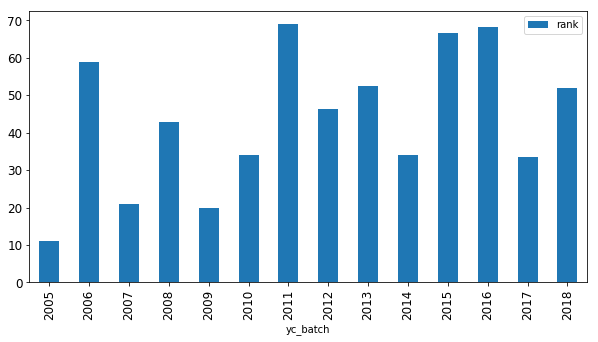

In [9]:
yc_year_ranking = yc.pivot_table(values='rank', index='yc_batch')
yc_year_ranking.plot(kind='bar', figsize=(10,5), fontsize=12)

## How many founders?

In this section I would like to find out the breakdown of founding teams, and how many startups in the top 100 had a solo founder. My expection is that majority of companies will have 2+ founders.

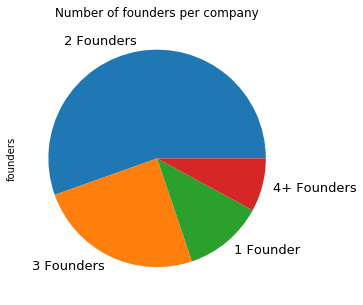

In [10]:
pattern = r'([A-Z])\w+'

number_of_founders = yc['founders'].str.count(pattern) / 2
number_of_founders.mean()

def founder_cats(val):
    if val < 2:
        return "1 Founder"
    elif val <3:
        return "2 Founders"
    elif val <4:
        return '3 Founders'
    else: 
        return "4+ Founders"
#number_of_founders.value_counts() 

founder_groups = number_of_founders.apply(founder_cats)
founder_groups = founder_groups.value_counts()
founder_groups.plot(kind='pie', figsize=[5,5], title='Number of founders per company', fontsize=13)

## How many companies were acquired?

In this step, I would like to find what percentage of companies were acquired, and who are the major acquirers. I can extract this information from the description column.  

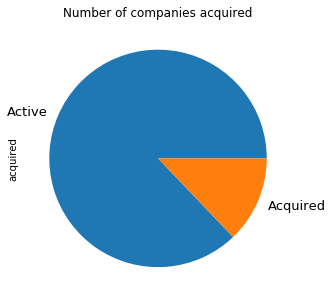

In [13]:
acquired_pattern = r"([Aa]cquired)"

yc['acquired'] = yc['description'].str.extract(acquired_pattern)
yc['acquired'] = yc['acquired'].fillna('Active')

yc_acquired = yc['acquired'].value_counts()
yc_acquired.plot(kind='pie', figsize=[5,5], title='Number of companies acquired', fontsize=13)

In [19]:
acquired_pattern = r"[Aa]cquired by ([A-Za-z]+)"

yc_acquired_by = yc['description'].str.extract(acquired_pattern)

yc['acquired_by'] = yc['description'].str.extract(acquired_pattern)
yc['acquired_by'].value_counts()

Square        2
Zynga         1
IBM           1
Amazon        1
Google        1
SiriusXM      1
Blackrock     1
JPMorgan      1
Conde         1
Salesforce    1
GM            1
Red           1
Name: acquired_by, dtype: int64

# Conclusion

In this project I analyzed Y Combinator's top 100 investments since its inception in 2005. Here are the biggest insights derived from the analysis. 

**Breakdown by Sector**

The most represented sector in the top 100 is B2B SaaS sector with 49 companies. Other significant categories included Consumer Products and Media. 

Companies in B2B SaaS and Consumer Product have created more than 20,000 jobs, more than half of total jobs created by top 100 YC companies. 

On average, companies in Consumer Product sector created the highest number of jobs - 500+. This result can mostly be attributed to AirBnB, which created 4,000 by itself.  

When it comes to ranking, FinTech companies were the highest ranked on average. Healthcare companies ranked lowest among the top 100. 

**YC's Best Year**

YC's companies created a lot of jobs. The best year of investments for the accelerator was 2009. Companies in this year created the largest number of jobs. This success can be mostly attributed to AirBnB. 

YC's best year when it comes to ranking is inconclusive. 

**Number of Founders per team**

Our analysis showed that amoung the top 100 YC companies, more than 50% of companies had 2 founders, and close to 25% had 3 founders. Only 12% of companies in the top 100 had a solo founder. 

**Major Acquirers** 

From the top 100, 13 companies were acquired and 1 went public (Dropbox). 

Our analysis showed that Square had the largest number of acquisitions with a grand total of 2. Other acquirers had 1 each. The list includes the likes of Google, Amazon, IBM, and Salesforce. 